In [ ]:
!pip install -U spacy
!python -m spacy download es_core_news_sm
!pip install -q wordcloud
!pip install unicodedata
!pip install spacy
!pip install emoji
!pip install -U nltk
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-09-13 00:11:30.217296: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 16.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement unicodedata (from versions: none)
ERROR: No matching distribution found for unicodedata
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pyp

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string
from keras.preprocessing.text import Tokenizer
import re
from bs4 import BeautifulSoup
import unicodedata
import spacy
import nltk
import re 
import unicodedata 
import nltk
import numpy as np
import emoji

In [ ]:
# Constants
# POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
DI_POS_TYPES = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'} 
POS_TYPES = list(DI_POS_TYPES.keys())

# Constraints on tokens
MIN_STR_LEN = 3
RE_VALID = '[a-zA-Z]'

In [ ]:
# Cargar el archivo textos.txt adjunto en la entrega
columna = 'descripcionhtml'
# columna = 'descripciontable'

df_text = pd.read_csv('result.csv', sep=',', encoding= 'ISO-8859-1')
df_text.descripcionhtml = df_text.descripcionhtml.fillna('vacio', inplace=False)
li_text = df_text[columna].tolist()

In [ ]:
# Remove accents function
def remove_accents(data): #ok
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")

def remove_all_special(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_accented_chars(text):
    import unicodedata 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9@#\s]' if not remove_digits else r'[^a-zA-Z@#\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_miscellaneous_tokens(text):
    list_ = ['del', 'que', 'con', 'la', "de", "la", "y", "en", "del", "el", "que", "a", "con", "los", "para", 
             "las", "por", "una", "basado", "correspondiente", "cobro",
             "agua", "vacio", ]
    if text in list_:
#         print(text)
        return ""
    return text 

In [ ]:
# Get stopwords, stemmer and lemmatizer
stopwords = nltk.corpus.stopwords.words('spanish')
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Process all quotes
li_tokens = []
li_token_lists = []
li_lem_strings = []

for i,text in enumerate(li_text):
    # Tokenize by sentence, then by lowercase word
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # Process all tokens per quote
    li_tokens_quote = []
    li_tokens_quote_lem = []
    for token in tokens:
        # Remove accents
        # t = remove_accents(token)
        # t = remove_accented_chars(t)
        t = remove_special_characters(token)
        t = remove_miscellaneous_tokens(t)

        # Remove punctuation
        t = str(t).translate(string.punctuation)
        li_tokens_quote.append(t)
        
        # Add token that represents "no lemmatization match"
        li_tokens_quote_lem.append("-") # this token will be removed if a lemmatization match is found below

        # Process each token
        if t not in stopwords:
            if re.search(RE_VALID, t):
                if len(t) >= MIN_STR_LEN:
                    # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer 
                    # (otherwise it assumes the word is a noun)
                    pos = nltk.pos_tag([t])[0][1][:2]
                    pos2 = 'n'  # set default to noun
                    if pos in DI_POS_TYPES:
                      pos2 = DI_POS_TYPES[pos]
                    
                    stem = stemmer.stem(t)
                    lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS
                    
                    if pos in POS_TYPES:
                        li_tokens.append((t, stem, lem, pos))

                        # Remove the "-" token and append the lemmatization match
                        li_tokens_quote_lem = li_tokens_quote_lem[:-1] 
                        li_tokens_quote_lem.append(lem)

    # Build list of token lists from lemmatized tokens
    li_token_lists.append(li_tokens_quote)
    
    # Build list of strings from lemmatized tokens
    str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
    li_lem_strings.append(str_li_tokens_quote_lem)
    
# Build resulting dataframes from lists
df_token_lists = pd.DataFrame(li_token_lists)
print("df_token_lists.head(5):")
print(df_token_lists.head(5).to_string())

# Replace None with empty string
for c in df_token_lists:
    if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
        df_token_lists[c].fillna(value='', inplace=True)

df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem quote'])

print()
print("")
print("df_lem_strings.head():")
print(df_lem_strings.head().to_string())

df_token_lists.head(5):
            0          1          2     3            4        5                6     7            8     9             10            11      12         13              14    15        16     17            18          19              20    21             22           23       24        25         26    27       28        29    30            31          32    33        34    35             36    37          38    39          40    41    42    43    44          45    46    47        48    49         50          51    52         53        54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83
0      prestar  servicios  asociados                     gestion                         informacion                                un  modelo        big            data         ingesta                datos              almacenamiento        procesamiento    

In [ ]:
# Add counts
print("Group by lemmatized words, add count and sort:")
df_all_words = pd.DataFrame(li_tokens, columns=['token', 'stem', 'lem', 'pos'])
df_all_words['counts'] = df_all_words.groupby(['lem'])['lem'].transform('count')
df_all_words = df_all_words.sort_values(by=['counts', 'lem'], ascending=[False, True]).reset_index()

print("Get just the first row in each lemmatized group")
df_words = df_all_words.groupby('lem').first().sort_values(by='counts', ascending=False).reset_index()
print("df_words.head(10):")
print(df_words.head(10))

Group by lemmatized words, add count and sort:
Get just the first row in each lemmatized group
df_words.head(10):
             lem  index          token          stem pos  counts
0    laboratorio    154    laboratorio   laboratorio  NN      37
1   inteligencia     16   inteligencia  inteligencia  NN      36
2      servicios      1      servicios      servicio  NN      36
3     artificial     17     artificial      artifici  JJ      34
4      analitica     13      analitica     analitica  NN      29
5        prestar      0        prestar       prestar  NN      25
6          datos      9          datos          dato  NN      24
7  profesionales    175  profesionales   profesional  NN      18
8       analisis     18       analisis       analisi  NN      17
9          apoyo    144          apoyo         apoyo  NN      16


In [ ]:
df_words = df_words[['lem', 'pos', 'counts']].head(200)
for v in POS_TYPES:
    df_pos = df_words[df_words['pos'] == v]
    print()
    print("POS_TYPE:", v)
    print(df_pos.head(10).to_string())


POS_TYPE: NN
              lem pos  counts
0     laboratorio  NN      37
1    inteligencia  NN      36
2       servicios  NN      36
4       analitica  NN      29
5         prestar  NN      25
6           datos  NN      24
7   profesionales  NN      18
8        analisis  NN      17
9           apoyo  NN      16
10     desarrollo  NN      16

POS_TYPE: JJ
             lem pos  counts
3     artificial  JJ      34
48   asistencial  JJ       6
57       general  JJ       5
68      nacional  JJ       5
107     regional  JJ       3
116          tic  JJ       3
123          big  JJ       3
175     integral  JJ       2

POS_TYPE: VB
Empty DataFrame
Columns: [lem, pos, counts]
Index: []

POS_TYPE: RB
        lem pos  counts
139  genere  RB       2


li_token_lists_flat[:10]: ['prestar', 'servicios', 'asociados', '', '', 'gestion', '', '', 'informacion', '']


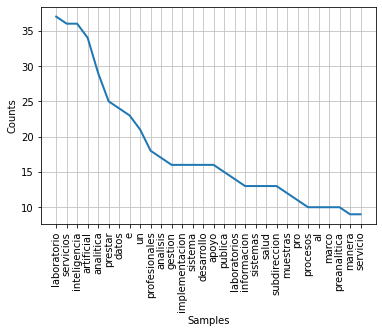

In [ ]:
li_token_lists_flat = [y for x in li_token_lists for y in x]  # flatten the list of token lists to a single list
print("li_token_lists_flat[:10]:", li_token_lists_flat[:10])

di_freq = nltk.FreqDist(li_token_lists_flat)
del di_freq['']
li_freq_sorted = sorted(di_freq.items(), key=lambda x: x[1], reverse=True)  # sorted list
    
di_freq.plot(30, cumulative=False)

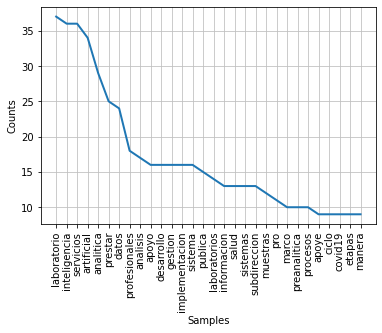

In [ ]:
li_lem_words = df_all_words['lem'].tolist()
di_freq2 = nltk.FreqDist(li_lem_words)
li_freq_sorted2 = sorted(di_freq2.items(), key=lambda x: x[1], reverse=True)  # sorted list
    
di_freq2.plot(30, cumulative=False)

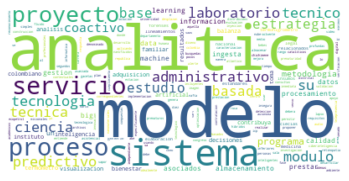

In [ ]:
text = " ".join([element[0] for element in di_freq.items()])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

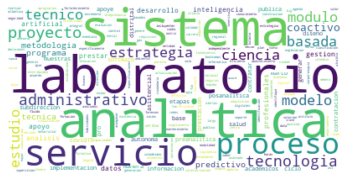

In [ ]:
text = " ".join([element[0] for element in di_freq2.items()])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
nlp = spacy.load("es_core_news_sm")

In [ ]:
doc = nlp(text)
for sentence in doc.sents:
#     print(sentence)
    for token in sentence:
        if token.lemma_ in ['artificial', 'inteligencia', 'analitica', 'software']:
            print("{}/{} => etiqueta {}/{} y dependencia {}".format(token, token.lemma_, token.pos_, token.tag_, token.dep_))


artificial/artificial => etiqueta ADJ/ADJ y dependencia amod
software/software => etiqueta PROPN/PROPN y dependencia obj
analiticas/analitica => etiqueta ADJ/ADJ y dependencia amod
